In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

from cataclop.ml.pipeline import factories

In [2]:
program = factories.Program.factory('default', version='1.1')

In [3]:
program.train(dataset_params = {
    #'from': '2013-05-10'
    'from': '2017-01-02',
    'to': '2018-10-01'
})

loading data 422765343d4f6e214c41091598dd9cb9 from cache
preparing model data
training knn_10
mea: 2.509045725958517
training knn_20
mea: 2.5045747171590196
training knn_30
mea: 2.502057772889169
training knn_40
mea: 2.4953947988686362
training knn_50
mea: 2.4953653676932745
training knn_100
mea: 2.501185150848523
training mlp_10
mea: 9.374155341101709
training mlp_20
mea: 11.16926945261839
training mlp_30
mea: 8.632692749571568
training mlp_40
mea: 11.055582842030008
training mlp_50
mea: 8.363475969393884
training mlp_100
mea: 8.949295724553757
training mlp_150
mea: 7.423341600854858
training gbr_10
mea: 2.5211011317332415
training gbr_20
mea: 2.616036254289806
training gbr_30
mea: 2.670447933227692
training gbr_40
mea: 2.7082881602534656
training gbr_50
mea: 2.7173644821839593
training gbr_100
mea: 2.76217219568899
training rf_10
mea: 3.2606286752435008
training rf_20
mea: 3.2728238548755266
training rf_30
mea: 3.2889800529879016
training rf_40
mea: 3.2908359582896285
training rf_50


In [4]:
program.dataset.save()
print(program.dataset.hash)
program.model.save()
print(program.model.hash)

422765343d4f6e214c41091598dd9cb9
23b7528ea96e432b06baa981458a43be


In [5]:
print('{} races from {} to {}'.format(program.df.race_id.nunique(), program.df.start_at.min(), program.df.start_at.max()))

11106 races from 2017-01-02 11:40:00 to 2018-06-21 18:35:00


In [6]:
from cataclop.ml import exploration

program.df.isnull().sum()

id                              0
age                             0
earnings                        0
final_odds                   1876
final_odds_ref                  0
handicap_distance               0
handicap_weight                 0
herder_id                   42976
horse_id                        0
imported_at_player              0
is_first_timer                  0
is_racing                       0
jockey_id                       0
music                           0
num                             0
owner_id                        1
placed_2_count                  0
placed_3_count                  0
placed_count                    0
placed_dividend                 0
placed_earnings                 0
position                    15311
post_position                   0
prev_year_earnings              0
race_count                      0
race_id                         0
time                        98057
trainer_id                      0
victory_count                   0
victory_earnin

In [7]:
import pandas as pd
from cataclop.ml import preprocessing

for model in program.model.models:
    clf = model['estimators'][-1]['pipeline'].steps[-1][1]
    if hasattr(clf, 'feature_importances_'):
        fi = pd.Series(clf.feature_importances_, index=program.model.features+preprocessing.get_dummy_features(model['estimators'][-1]['dummies']))
        print(model['name'])
        print(fi.sort_values(ascending=False)[0:100])
        print("---\n")


gbr_10
odds_9                                          0.186624
victory_earnings_r                              0.169410
hist_1_pos                                      0.116700
placed_earnings_r                               0.099547
handicap_weight_r                               0.071116
placed_3_count                                  0.067156
odds_8                                          0.060890
declared_player_count                           0.054153
victory_earnings                                0.040901
odds_4                                          0.031464
prev_year_earnings_std                          0.025511
placed_earnings_amin                            0.017523
hist_2_pos                                      0.013554
category_value_MONTE                            0.012134
placed_2_count_r                                0.009397
odds_7                                          0.007086
victory_earnings_amax                           0.006819
victory_count_r         

rf_100
victory_earnings_r                              0.039477
placed_2_count_r                                0.026958
placed_3_count_r                                0.026635
race_count_r                                    0.026311
prev_year_earnings_r                            0.026296
handicap_weight_r                               0.025912
hist_2_pos                                      0.025676
hist_1_pos                                      0.025566
placed_earnings_r                               0.024863
odds_9                                          0.023507
victory_count_r                                 0.023329
hist_3_pos                                      0.023104
victory_earnings                                0.022966
odds_1                                          0.022888
odds_4                                          0.022323
odds_2                                          0.020513
hist_4_pos                                      0.020135
victory_earnings_std    

In [84]:
program.bet(N=1, max_odds=20)
bets = program.bets
bets['profit'].describe()

count    163217.000000
mean         -0.182112
std           3.679184
min          -1.000000
25%          -1.000000
50%          -1.000000
75%          -1.000000
max         138.600000
Name: profit, dtype: float64

In [12]:
program.

28

In [114]:
bets.date.dtype

dtype('O')

---
COURSE_A_CONDITIONS	-589.50	+3422.00	+3422.00
---
pred_mlp_30_1: 	 -82.90 	 +518 	 -0.16
pred_mlp_50_1: 	 -111.80 	 +516 	 -0.22
pred_mlp_20_1: 	 -57.40 	 +499 	 -0.12
pred_mlp_10_1: 	 -106.10 	 +495 	 -0.21
pred_mlp_100_1: 	 -72.10 	 +471 	 -0.15
pred_mlp_40_1: 	 -90.20 	 +466 	 -0.19
pred_mlp_150_1: 	 -69.00 	 +457 	 -0.15


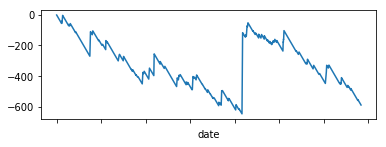

---
HANDICAP	+495.40	+2595.00	+2595.00
---
pred_mlp_50_1: 	 +119.30 	 +400 	 +0.30
pred_mlp_10_1: 	 +42.30 	 +394 	 +0.11
pred_mlp_30_1: 	 +112.20 	 +367 	 +0.31
pred_mlp_40_1: 	 +38.80 	 +359 	 +0.11
pred_mlp_20_1: 	 +40.40 	 +359 	 +0.11
pred_mlp_150_1: 	 +87.80 	 +359 	 +0.24
pred_mlp_100_1: 	 +54.60 	 +357 	 +0.15


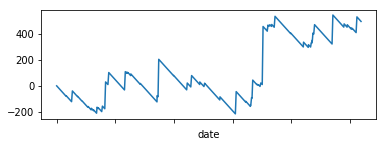

---
AUTOSTART	-302.80	+1669.00	+1669.00
---
pred_mlp_50_1: 	 -53.40 	 +318 	 -0.17
pred_mlp_100_1: 	 -29.50 	 +250 	 -0.12
pred_mlp_10_1: 	 -31.90 	 +238 	 -0.13
pred_mlp_30_1: 	 -102.40 	 +223 	 -0.46
pred_mlp_40_1: 	 +6.80 	 +219 	 +0.03
pred_mlp_150_1: 	 -80.00 	 +213 	 -0.38
pred_mlp_20_1: 	 -12.40 	 +208 	 -0.06


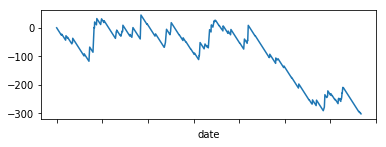

---
HANDICAP_DIVISE	+781.20	+1556.00	+1556.00
---
pred_mlp_50_1: 	 +51.80 	 +240 	 +0.22
pred_mlp_100_1: 	 +133.20 	 +227 	 +0.59
pred_mlp_20_1: 	 +101.10 	 +223 	 +0.45
pred_mlp_30_1: 	 +112.00 	 +222 	 +0.50
pred_mlp_40_1: 	 +110.40 	 +220 	 +0.50
pred_mlp_10_1: 	 +155.80 	 +215 	 +0.72
pred_mlp_150_1: 	 +116.90 	 +209 	 +0.56


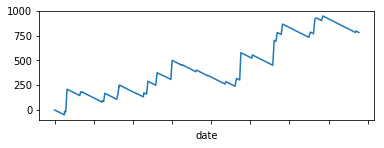

---
A_RECLAMER	-404.30	+850.00	+850.00
---
pred_mlp_50_1: 	 -66.70 	 +140 	 -0.48
pred_mlp_20_1: 	 -53.60 	 +128 	 -0.42
pred_mlp_100_1: 	 -50.20 	 +126 	 -0.40
pred_mlp_40_1: 	 -51.70 	 +120 	 -0.43
pred_mlp_150_1: 	 -53.70 	 +115 	 -0.47
pred_mlp_10_1: 	 -71.00 	 +112 	 -0.63
pred_mlp_30_1: 	 -57.40 	 +109 	 -0.53


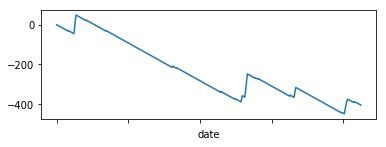

---
HANDICAP_CATEGORIE_DIVISE	-78.20	+542.00	+542.00
---
pred_mlp_50_1: 	 -52.30 	 +97 	 -0.54
pred_mlp_100_1: 	 -12.10 	 +83 	 -0.15
pred_mlp_150_1: 	 -7.90 	 +75 	 -0.11
pred_mlp_10_1: 	 +13.40 	 +75 	 +0.18
pred_mlp_40_1: 	 -11.10 	 +72 	 -0.15
pred_mlp_20_1: 	 -7.30 	 +72 	 -0.10
pred_mlp_30_1: 	 -0.90 	 +68 	 -0.01


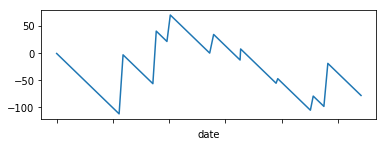

---
INTERNATIONALE_AUTOSTART	-51.80	+413.00	+413.00
---
pred_mlp_10_1: 	 -12.90 	 +77 	 -0.17
pred_mlp_20_1: 	 +24.60 	 +61 	 +0.40
pred_mlp_30_1: 	 -4.10 	 +60 	 -0.07
pred_mlp_50_1: 	 -17.20 	 +58 	 -0.30
pred_mlp_40_1: 	 -32.70 	 +55 	 -0.59
pred_mlp_100_1: 	 -3.10 	 +55 	 -0.06
pred_mlp_150_1: 	 -6.40 	 +47 	 -0.14


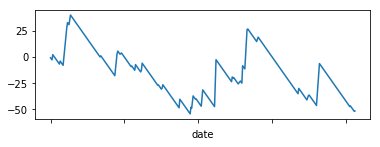

---
HANDICAP_DE_CATEGORIE	-188.00	+265.00	+265.00
---
pred_mlp_50_1: 	 -30.00 	 +41 	 -0.73
pred_mlp_100_1: 	 -29.00 	 +40 	 -0.72
pred_mlp_150_1: 	 -27.00 	 +38 	 -0.71
pred_mlp_10_1: 	 -27.00 	 +38 	 -0.71
pred_mlp_20_1: 	 -25.00 	 +36 	 -0.69
pred_mlp_30_1: 	 -25.00 	 +36 	 -0.69
pred_mlp_40_1: 	 -25.00 	 +36 	 -0.69


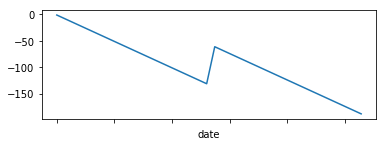

---
NATIONALE_AUTOSTART	-67.80	+244.00	+244.00
---
pred_mlp_50_1: 	 -23.00 	 +50 	 -0.46
pred_mlp_20_1: 	 +12.90 	 +36 	 +0.36
pred_mlp_30_1: 	 -18.10 	 +33 	 -0.55
pred_mlp_40_1: 	 -20.50 	 +33 	 -0.62
pred_mlp_10_1: 	 -2.80 	 +33 	 -0.08
pred_mlp_100_1: 	 -2.20 	 +30 	 -0.07
pred_mlp_150_1: 	 -14.10 	 +29 	 -0.49


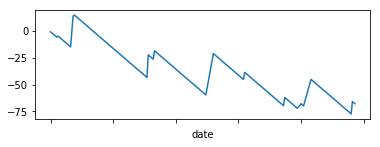

---
COURSE_A_CONDITION_QUALIF_HP	-0.70	+161.00	+161.00
---
pred_mlp_50_1: 	 +2.50 	 +28 	 +0.09
pred_mlp_100_1: 	 +3.70 	 +24 	 +0.15
pred_mlp_150_1: 	 -7.00 	 +23 	 -0.30
pred_mlp_10_1: 	 +3.40 	 +22 	 +0.15
pred_mlp_20_1: 	 +0.10 	 +22 	 +0.00
pred_mlp_30_1: 	 -1.70 	 +21 	 -0.08
pred_mlp_40_1: 	 -1.70 	 +21 	 -0.08


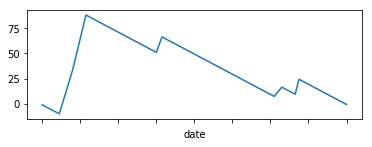

---
EUROPEENNE_AUTOSTART	+34.80	+129.00	+129.00
---
pred_mlp_50_1: 	 -1.90 	 +31 	 -0.06
pred_mlp_100_1: 	 -2.60 	 +20 	 -0.13
pred_mlp_150_1: 	 +10.40 	 +19 	 +0.55
pred_mlp_10_1: 	 +17.00 	 +17 	 +1.00
pred_mlp_40_1: 	 +2.40 	 +15 	 +0.16
pred_mlp_30_1: 	 +8.00 	 +14 	 +0.57
pred_mlp_20_1: 	 +1.50 	 +13 	 +0.12


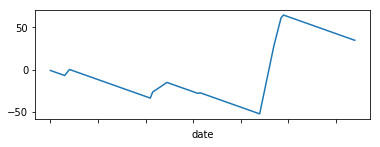

---
GROUPE_I	-77.50	+127.00	+127.00
---
pred_mlp_100_1: 	 -16.70 	 +25 	 -0.67
pred_mlp_20_1: 	 -16.50 	 +23 	 -0.72
pred_mlp_10_1: 	 -11.50 	 +18 	 -0.64
pred_mlp_30_1: 	 -4.60 	 +18 	 -0.26
pred_mlp_150_1: 	 -8.90 	 +16 	 -0.56
pred_mlp_40_1: 	 -13.80 	 +15 	 -0.92
pred_mlp_50_1: 	 -5.50 	 +12 	 -0.46


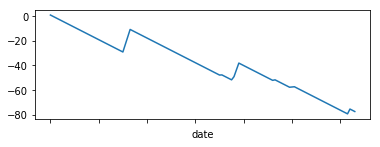

---
AMATEURS_AUTOSTART	-50.30	+118.00	+118.00
---
pred_mlp_50_1: 	 +5.60 	 +20 	 +0.28
pred_mlp_100_1: 	 -15.90 	 +19 	 -0.84
pred_mlp_10_1: 	 -12.50 	 +17 	 -0.74
pred_mlp_40_1: 	 -11.20 	 +17 	 -0.66
pred_mlp_20_1: 	 -12.90 	 +16 	 -0.81
pred_mlp_30_1: 	 -15.00 	 +15 	 -1.00
pred_mlp_150_1: 	 +11.60 	 +14 	 +0.83


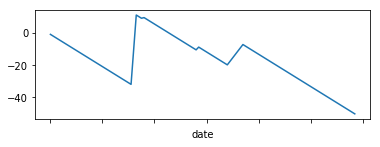

---
GROUPE_II	+76.00	+108.00	+108.00
---
pred_mlp_30_1: 	 +2.60 	 +18 	 +0.14
pred_mlp_10_1: 	 +8.60 	 +17 	 +0.51
pred_mlp_50_1: 	 +4.60 	 +16 	 +0.29
pred_mlp_20_1: 	 +13.30 	 +16 	 +0.83
pred_mlp_150_1: 	 +15.30 	 +14 	 +1.09
pred_mlp_100_1: 	 +15.30 	 +14 	 +1.09
pred_mlp_40_1: 	 +16.30 	 +13 	 +1.25


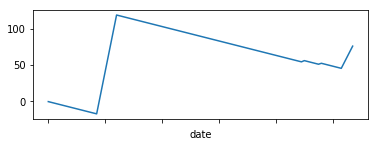

---
GROUPE_III	-101.00	+105.00	+105.00
---
pred_mlp_20_1: 	 -17.00 	 +19 	 -0.89
pred_mlp_30_1: 	 -16.00 	 +16 	 -1.00
pred_mlp_150_1: 	 -15.00 	 +15 	 -1.00
pred_mlp_10_1: 	 -15.00 	 +15 	 -1.00
pred_mlp_50_1: 	 -12.00 	 +14 	 -0.86
pred_mlp_100_1: 	 -14.00 	 +14 	 -1.00
pred_mlp_40_1: 	 -12.00 	 +12 	 -1.00


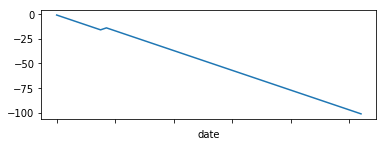

---
APPRENTIS_LADS_JOCKEYS_AUTOSTART	+36.10	+83.00	+83.00
---
pred_mlp_50_1: 	 +2.50 	 +19 	 +0.13
pred_mlp_100_1: 	 +2.70 	 +15 	 +0.18
pred_mlp_150_1: 	 +7.60 	 +12 	 +0.63
pred_mlp_10_1: 	 +12.00 	 +11 	 +1.09
pred_mlp_20_1: 	 +8.60 	 +11 	 +0.78
pred_mlp_40_1: 	 +9.70 	 +8 	 +1.21
pred_mlp_30_1: 	 -7.00 	 +7 	 -1.00


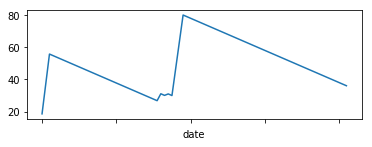

---
INCONNU	+56.30	+52.00	+52.00
---
pred_mlp_50_1: 	 +14.20 	 +9 	 +1.58
pred_mlp_10_1: 	 +7.50 	 +9 	 +0.83
pred_mlp_40_1: 	 +8.50 	 +8 	 +1.06
pred_mlp_100_1: 	 +8.50 	 +8 	 +1.06
pred_mlp_30_1: 	 +12.10 	 +7 	 +1.73
pred_mlp_150_1: 	 +9.50 	 +7 	 +1.36
pred_mlp_20_1: 	 -4.00 	 +4 	 -1.00


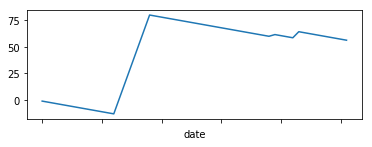

---
A_RECLAMER_AUTOSTART	-32.00	+32.00	+32.00
---
pred_mlp_100_1: 	 -6.00 	 +6 	 -1.00
pred_mlp_150_1: 	 -6.00 	 +6 	 -1.00
pred_mlp_30_1: 	 -6.00 	 +6 	 -1.00
pred_mlp_50_1: 	 -5.00 	 +5 	 -1.00
pred_mlp_10_1: 	 -3.00 	 +3 	 -1.00
pred_mlp_40_1: 	 -3.00 	 +3 	 -1.00
pred_mlp_20_1: 	 -3.00 	 +3 	 -1.00


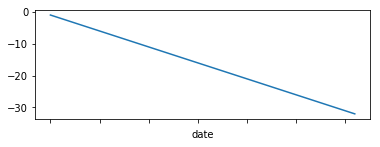

---
APPRENTIS_LADS_JOCKEYS_A_RECLAMER_AUTOSTART	-22.00	+22.00	+22.00
---
pred_mlp_40_1: 	 -5.00 	 +5 	 -1.00
pred_mlp_30_1: 	 -4.00 	 +4 	 -1.00
pred_mlp_100_1: 	 -3.00 	 +3 	 -1.00
pred_mlp_150_1: 	 -3.00 	 +3 	 -1.00
pred_mlp_20_1: 	 -3.00 	 +3 	 -1.00
pred_mlp_50_1: 	 -3.00 	 +3 	 -1.00
pred_mlp_10_1: 	 -1.00 	 +1 	 -1.00


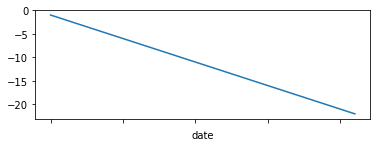

---
AMATEURS_INTERNATIONALE_AUTOSTART	-1.20	+16.00	+16.00
---
pred_mlp_20_1: 	 +0.30 	 +4 	 +0.07
pred_mlp_30_1: 	 -1.10 	 +3 	 -0.37
pred_mlp_100_1: 	 +1.30 	 +3 	 +0.43
pred_mlp_10_1: 	 -2.00 	 +2 	 -1.00
pred_mlp_40_1: 	 +2.30 	 +2 	 +1.15
pred_mlp_150_1: 	 -1.00 	 +1 	 -1.00
pred_mlp_50_1: 	 -1.00 	 +1 	 -1.00


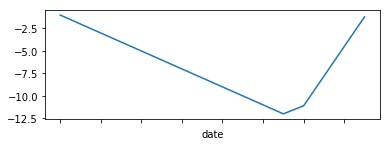

---
HANDICAP_A_RECLAMER	-8.00	+8.00	+8.00
---
pred_mlp_50_1: 	 -2.00 	 +2 	 -1.00
pred_mlp_100_1: 	 -1.00 	 +1 	 -1.00
pred_mlp_150_1: 	 -1.00 	 +1 	 -1.00
pred_mlp_40_1: 	 -1.00 	 +1 	 -1.00
pred_mlp_20_1: 	 -1.00 	 +1 	 -1.00
pred_mlp_10_1: 	 -1.00 	 +1 	 -1.00
pred_mlp_30_1: 	 -1.00 	 +1 	 -1.00


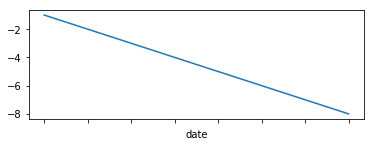

---
AMATEURS_EUROPEENNE_AUTOSTART	-5.00	+5.00	+5.00
---
pred_mlp_40_1: 	 -1.00 	 +1 	 -1.00
pred_mlp_20_1: 	 -1.00 	 +1 	 -1.00
pred_mlp_10_1: 	 -1.00 	 +1 	 -1.00
pred_mlp_30_1: 	 -1.00 	 +1 	 -1.00
pred_mlp_50_1: 	 -1.00 	 +1 	 -1.00


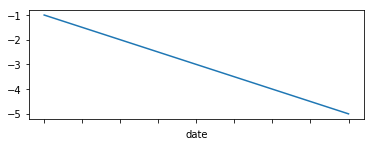

---
QUALIFICATION_ACCAF	-3.00	+3.00	+3.00
---
pred_mlp_10_1: 	 -1.00 	 +1 	 -1.00
pred_mlp_50_1: 	 -1.00 	 +1 	 -1.00
pred_mlp_100_1: 	 -1.00 	 +1 	 -1.00


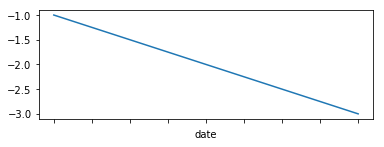

---
FINALE_REGIONALE_ACCAF	-2.00	+2.00	+2.00
---
pred_mlp_150_1: 	 -1.00 	 +1 	 -1.00
pred_mlp_50_1: 	 -1.00 	 +1 	 -1.00


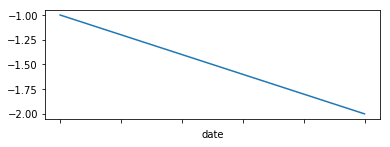

In [146]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

bb = bets[(bets['target'].str.contains('^pred_mlp_'))].groupby('id').filter(lambda r: r['num'].nunique() == 1 ).copy()
#bb = bets.groupby('id').filter(lambda r: (r['target'] == 'pred_mlp_1').sum() == 0 and (r['target'] == 'pred_knn_10_1').sum() == 1  )

def f(r):
    n1 = r[(r['target'] == 'pred_mlp_100_1')]['num']
    n2 = r[(r['target'] == 'pred_rf_100_1')]['num']
    
    if not len(n1) and len(n2):
        return True
    if not len(n2) and len(n1):
        return True
    
    if n1.max() != n2.max():
        return True
    
    return False

#bb = bets.groupby('id').filter(f)

f = 'sub_category'

for s in bb[f].value_counts().index:
    x = bb[bb[f] == s].copy()
    print("---\n{}\t{:+.2f}\t{:+.2f}\t{:+.2f}\n---".format(s, x['profit'].sum(), x['bet'].sum(), len(x)))
    for t in x['target'].value_counts().index:
        bbb = x[(x['target'] == t) & (x['odds_ref'] > 0)].copy()
        print("{:10s}: \t {:+.2f} \t {:+.0f} \t {:+.2f}".format(t, bbb.profit.sum(), bbb.profit.count(), bbb.profit.mean()) )
        
    x['stash'] = x['profit'].cumsum()

    fig, axs = plt.subplots(1,1)
    x['stash'].plot(figsize=(6, 2))
    plt.show()

In [ ]:
bb[(bb['target']=='pred_rf_100_1') & (bb['sub_category'

/Users/pourquoi/.local/share/virtualenvs/cataclop-django-M9amAh3O/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


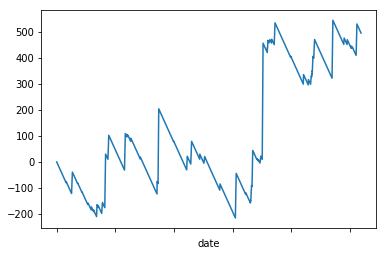

In [56]:
%matplotlib inline
bbb = bb[(bb['sub_category']=='HANDICAP')]
bbb['stash'] = bbb['profit'].cumsum()
bbb['stash'].plot()